In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.append('/usr/local/lib/python2.7/site-packages')
import cv2
from sklearn import cross_validation
import random

In [3]:
allTraingData = np.genfromtxt('train.csv', delimiter=',')

In [21]:
trainingPixmaps = allTraingData[:,9:438]
trainingClasses =  allTraingData[:,1]
bookIds = allTraingData[:,2]

newtrainingPixmaps = []
for i in range (0, len(trainingPixmaps)):
    pont = np.append(trainingPixmaps[i], bookIds[i])
    newtrainingPixmaps.append(pont)



X_train, X_test, y_train, y_test = cross_validation.train_test_split (trainingPixmaps, trainingClasses, 
                                                                      test_size=0.10, random_state=0)

In [4]:
allTestData = np.genfromtxt('test.csv', delimiter = ',')
newTestPixmaps = []
for i in range (0, len(allTestData)):
    pont = np.append(allTestData[:,9:438][i], allTestData[:,2][i])
    newTestPixmaps.append(pont)

In [8]:
def removeNoise(image) :
    image = image.reshape(33,13)
    image = image.astype(np.uint8)
    ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    th1 = th1.reshape(429)
    return th1

In [9]:
def removeNoise2(image) :
    image = image.reshape(40,15)
    image = image.astype(np.uint8)
    ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    th1 = th1.reshape(600)
    return th1

In [10]:
def removeWhitespace(image):
    image = image.reshape(33,13)
    rowSums = np.sum(image, axis = 1)
    colSums = np.sum(image, axis = 0)
    blankRowsStart = 0
    blankRowsEnd = 13
    blankColumnsStart = 0
    blankColumsnEnd = 33
    
    #Top rows margin
    isBlank = 1
    count = 0;
    while(isBlank and count != 32) :
        if(rowSums[count] == 0) :
            count += 1
        else :
            isBlank = 0
            
    blankRowsStart = 0 + count
    
    #Bottom rows margin
    isBlank = 1
    count = 32;
    while(isBlank and count != 1) :
        if(rowSums[count] == 0) :
            count -= 1
        else :
            isBlank = 0
            
    blankRowsEnd = count
    
    
        #Left cols margin
    isBlank = 1
    count = 0;
    while(isBlank and count != 12) :
        if(colSums[count] == 0) :
            count += 1
        else :
            isBlank = 0
            
    blankColumnsStart = 0 + count
    
    #Bottom rows margin
    isBlank = 1
    count = 12;
    while(isBlank and count != 1) :
        if(colSums[count] == 0) :
            count -= 1
        else :
            isBlank = 0
            
    blankColumsnEnd =  count
    
    if blankColumsnEnd != 12 :
        blankColumsnEnd += 1
        
    if blankRowsEnd != 32 :
        blankRowsEnd += 1
        
    if (blankRowsStart == 32) :
        blankRowsStart = 0
    if (blankColumnsStart == 12):
        blankColumnsStart = 0
        
    #print(blankRowsStart)
    #print(blankRowsEnd)
    #print(blankColumnsStart)
    #print(blankColumsnEnd)
    smallImage = image[blankRowsStart:blankRowsEnd,blankColumnsStart:blankColumsnEnd]
    scaledImage = cv2.resize(smallImage, (15,40))
    #resized_image = cv2.resize(image, (100, 50)) 
    return scaledImage.reshape(600)


In [11]:
def clean (point) :
    img1 = removeNoise(point)
    img2 = removeWhitespace(img1)
    img3 = removeNoise2(img2)
    return img3

In [20]:
print(len(X_train[0]))

430


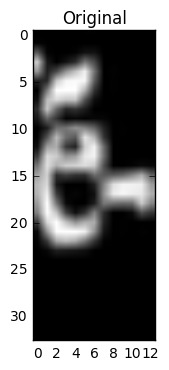

In [42]:
img = X_train[0].reshape(33,13) 
#cleaned = clean(test).reshape(40,15) 
plt.imshow(img, 'gray')
#plt.imshow(removeNoise2(removeWhitespace(removeNoise(img))).reshape(40,15) , 'gray')
plt.title("Original")
plt.show()

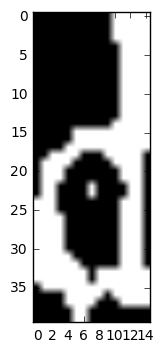

In [9]:
img = X_train[0]
cleaned = clean(test).reshape(40,15) 
plt.imshow(cleaned, 'gray')
plt.show()

In [10]:
def returnZones (img) : # image of size 40*15
    img = np.array(img.reshape(40,15))
    zones = []
    for i in range (0 , 2) :
        for j in range (0,3) :
            rowStart = i*20
            rowEnd = (i+1) * 20
            colStart = j*5
            colEnd = (j+1)*5
            aZone = img[rowStart:rowEnd,colStart:colEnd]
            zones.append(aZone)
    return zones
    

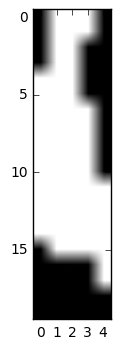

In [11]:
zoned = returnZones(cleaned)
plt.imshow(zoned[3], 'gray')
plt.show()

In [12]:
# For each zone, can get the following features:
# The magnitude
# Edge detection

# 

In [13]:
def makeBinary(zone) :
    zone = np.clip(zone,0,1)
    return zone.reshape(20,5)
    

In [14]:
def makeSobel(img) :
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    return (sobelx, sobely)

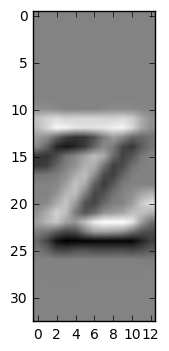

In [15]:
imgTest = X_train[1]
imgTest = imgTest.reshape(33,13)
(sobelx, sobely) = makeSobel(imgTest)
sobely = sobely.reshape(33,13)
#print (sobely)
plt.imshow(sobely,'gray')
plt.show()

In [16]:
def calcFeat(dataset) :  
    calcFeatures = []
    for i in range (0,len(dataset)) :
    #for i in range (0,1) :
        if (i % 10000 == 0) :
            print ("10,000 features completed")
        point = dataset[i]
        pointsFeatures = []
        cleanPoint = clean(point)
        zones = returnZones(cleanPoint)
        pointsFeatures.append(bookIds[i])
        for z in range (0, len(zones)):
            #calc some features
            #Then add them
            zone = zones[z]
            binaryZone = makeBinary(zone)
            zoneMag = sum(sum(binaryZone))
            (sobelX, sobelY) = makeSobel(binaryZone)
            abssobx = int(sum(sum(abs(sobelX))))
            abssoby = int(sum(sum(abs(sobelY))))
            pointsFeatures.append(zoneMag)
            pointsFeatures.append(abssobx)
            pointsFeatures.append(abssoby)

        calcFeatures.append(pointsFeatures)
    return calcFeatures
        
        
    
    

In [17]:
traingingFeatures = calcFeat(X_train)


10,000 features completed
10,000 features completed
10,000 features completed
10,000 features completed
10,000 features completed


In [18]:
cvFeatures = calcFeat(X_test)

10,000 features completed
10,000 features completed


In [19]:
# Random forest from these features :D

In [5]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=250)
forest.fit(newtrainingPixmaps, trainingClasses)
#forest.fit(traingingFeatures, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [6]:
pred = forest.predict(newTestPixmaps)

In [7]:
print(3)

3


In [8]:
toSub = []

for i in range (0,len(newTestPixmaps)):
    temp = []
    temp.append(int(allTestData[:,0][i]))
    temp.append(int(pred[i]))
    toSub.append(temp)


In [9]:
print(3)

3


In [11]:
import csv
writer = csv.writer(open("ZonesWithRFTest.csv", "wb"))
writer.writerows(toSub)
#writer.close()

In [ ]:
# Now build a classifier
# Lets go for MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(algorithm='adam', alpha=1e-5, hidden_layer_sizes=(85), random_state=1)
clf.fit(traingingFeatures, y_train)
clf.score(cvFeatures, y_test) 
# Layer of size 66 -> 0.610
# Layer of size 50 -> 0.597

In [ ]:
# Test model on itself (crazy thought, to remove outliers?)
predicitonOfTraining = clf.predict(traingingFeatures)

In [ ]:
correct = 0
correctFeatures = []
correctClass = []
for i in range (0, len(traingingFeatures)):
    if y_train[i] == predicitonOfTraining[i] :
        correctFeatures.append(traingingFeatures[i])
        correctClass.append(predicitonOfTraining[i])
        correct += 1
print (correct)
print (len(traingingFeatures))

In [ ]:
test = np.repeat(0,98)
test[1] = 4
print(test[1])

In [ ]:
# Crazy thought : retrain on correct
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(algorithm='adam', alpha=1e-5, hidden_layer_sizes=(60), random_state=1)
clf.fit(correctFeatures, correctClass)
clf.score(cvFeatures, y_test) 

In [ ]:
allTestData = np.genfromtxt('test.csv', delimiter = ',')
testIds = allTestData[:,0]
testPixmaps = allTestData[:,9:438]


In [ ]:
testFeatures = calcFeat(testPixmaps)

In [ ]:
prediciton = clf.predict(testFeatures)

In [ ]:
results = []
for i in range (0, len(testFeatures)) :
    temp = []
    temp.append(int(testIds[i]))
    temp.append(int(prediciton[i]))
    results.append(temp)

In [ ]:
print results[0]

In [ ]:
import csv

with open("output2.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(results)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = 5, algorithm='ball_tree').fit(traingingFeatures)
distances, indices = nbrs.kneighbors(np.array(cvFeatures))

In [ ]:
classification = []
totalCorrect = 0
for i in range (0,len(indices)):
    nearestPoints = indices[i]
    closestPoints = []
    for j in range (0,5) :
        closestPoints.append(y_train[nearestPoints[j]])
        
    from collections import Counter
    data = Counter(closestPoints)
    classification.append(data.most_common(1))  # Returns the highest occurring item

classs = classification[3]
#print (classs)
#print (classs[0][0])
for i in range (0,len(indices)) :
    if (classification[i][0][0] == y_test[i]):
      totalCorrect += 1

print (totalCorrect)
print(len(indices))